# 기존 동화 JSON으로 표지 이미지 생성
## Imagen 3 (나노바나나) 활용

**사용 방법:**
1. 기존 동화 JSON 파일 업로드
2. Gemini API 키 입력
3. 표지 이미지 자동 생성 (W:149, H:120)
4. 다운로드

## 1단계: 라이브러리 설치

In [1]:
!pip install google-generativeai pillow -q

import json
import os
from getpass import getpass
import google.generativeai as genai
from PIL import Image
import io
from google.colab import files

print("✅ 라이브러리 설치 완료")

✅ 라이브러리 설치 완료


In [9]:
# 최신 버전으로 업그레이드
!pip install --upgrade google-generativeai -q

# 버전 확인
import google.generativeai as genai
print(f"✅ google-generativeai 버전: {genai.__version__}")

# 사용 가능한 모델 확인
print("\n📋 사용 가능한 Imagen 모델:")
for model in genai.list_models():
    if 'imagen' in model.name.lower():
        print(f"  - {model.name}")

✅ google-generativeai 버전: 0.8.5

📋 사용 가능한 Imagen 모델:
  - models/imagen-4.0-generate-preview-06-06
  - models/imagen-4.0-ultra-generate-preview-06-06
  - models/imagen-4.0-generate-001
  - models/imagen-4.0-ultra-generate-001
  - models/imagen-4.0-fast-generate-001


## 2단계: Gemini API 설정

In [2]:
# Gemini API 키 입력
GEMINI_API_KEY = getpass("Gemini API Key (AI...): ")
genai.configure(api_key=GEMINI_API_KEY)

print("✅ Gemini API 설정 완료")

Gemini API Key (AI...): ··········
✅ Gemini API 설정 완료


## 3단계: 동화 JSON 파일 업로드

In [10]:
# JSON 파일 업로드
print("📂 동화 JSON 파일을 업로드하세요:")
uploaded = files.upload()

# 업로드된 파일 이름 가져오기
json_filename = list(uploaded.keys())[0]
print(f"\n✅ 업로드 완료: {json_filename}")

# JSON 파일 읽기
with open(json_filename, 'r', encoding='utf-8') as f:
    story_data = json.load(f)

# 동화 정보 출력
print("\n📖 동화 정보:")
print(f"제목: {story_data['story_info']['title']}")
print(f"테마: {story_data['story_info'].get('theme', 'N/A')}")
print(f"키워드: {', '.join(story_data['story_info']['keywords'])}")
print(f"줄거리: {story_data['story_info']['summary'][:100]}...")

📂 동화 JSON 파일을 업로드하세요:


Saving 유민이의_특별한_한복_찾기_20251207_2253.json to 유민이의_특별한_한복_찾기_20251207_2253 (1).json

✅ 업로드 완료: 유민이의_특별한_한복_찾기_20251207_2253 (1).json

📖 동화 정보:
제목: 유민이의 특별한 한복 찾기
테마: 따뜻하고 신비로운 분위기
키워드: 동대문 시장, 한복, 전통 장신구
줄거리: 유민이는 동대문 시장을 방문하여 엄마와 함께 한복 가게를 둘러보던 중, 반짝이는 노리개를 발견한다. 그 노리개를 만지자마자 유민은 꿈속에서 아름다운 한복을 입은 자신을 발견하게 되...


## 4단계: 표지 이미지 생성 함수 정의

In [32]:
def generate_cover_from_story(story_data, output_path="cover_image.png"):
    """
    동화 JSON 데이터로부터 표지 이미지 생성
    Imagen 4.0 Fast - REST API 전용
    """
    print("\n🎨 [이미지 생성 시작]")
    print("="*70)

    # 동화 정보 추출
    title = story_data['story_info']['title']
    summary = story_data['story_info']['summary']
    keywords = story_data['story_info']['keywords']

    print(f"📖 제목: {title}")
    print(f"🏷️ 키워드: {', '.join(keywords)}")

    # 텍스트 없는 이미지 생성을 위한 강화된 프롬프트
    image_prompt = """
    A beautiful watercolor illustration of a young Korean girl in traditional hanbok.

    Character: Korean child with black hair, joyful curious expression, wearing colorful hanbok (pink and blue traditional Korean dress)

    Background: Soft dreamy bokeh, warm pastel colors, abstract traditional Korean patterns, gentle magical atmosphere

    Art style: Children's book illustration, soft watercolor painting, warm gentle colors, whimsical

    Quality: Professional high-quality artwork

    ABSOLUTELY NO TEXT. NO letters. NO Korean characters. NO words. NO signs. Clean illustration only.
    """

    print(f"\n📝 프롬프트 준비 완료 (텍스트 없음 강조)")
    print("-"*70)

    try:
        print("⏳ Imagen 4.0 Fast로 이미지 생성 중... (30-60초 소요)")

        import requests
        import base64

        # REST API 직접 호출
        api_key = GEMINI_API_KEY
        url = f"https://generativelanguage.googleapis.com/v1beta/models/imagen-4.0-fast-generate-001:predict?key={api_key}"

        payload = {
            "instances": [{
                "prompt": image_prompt
            }],
            "parameters": {
                "sampleCount": 1,
                "aspectRatio": "3:4"
            }
        }

        headers = {"Content-Type": "application/json"}
        response = requests.post(url, json=payload, headers=headers, timeout=90)

        if response.status_code == 200:
            result = response.json()

            # 이미지 데이터 추출
            if 'predictions' in result and len(result['predictions']) > 0:
                prediction = result['predictions'][0]

                # 여러 가능한 키 확인
                image_b64 = None
                for key in ['bytesBase64Encoded', 'image', 'imageData', 'data']:
                    if key in prediction:
                        image_b64 = prediction[key]
                        print(f"✅ 이미지 데이터 추출 성공 (키: {key})")
                        break

                if image_b64:
                    # Base64 디코딩 및 PIL Image 변환
                    image_bytes = base64.b64decode(image_b64)
                    pil_image = Image.open(io.BytesIO(image_bytes))

                    print(f"✅ 원본 이미지 생성 성공! (크기: {pil_image.size})")

                    # 149 x 120 크기로 리사이즈
                    resized_image = pil_image.resize((315, 424), Image.Resampling.LANCZOS)
                    resized_image.save(output_path, format='PNG', quality=95)

                    print(f"✅ 리사이즈 완료: {resized_image.size} (W:315, H:424)")
                    print(f"💾 저장 완료: {output_path}")
                    print("="*70)

                    # Colab에서 미리보기
                    print("\n📷 생성된 표지 이미지:")
                    display(resized_image)

                    return output_path, resized_image
                else:
                    print(f"⚠️ 응답 구조: {prediction.keys()}")
                    raise Exception("이미지 데이터를 찾을 수 없습니다")
            else:
                print(f"⚠️ 전체 응답: {result}")
                raise Exception("predictions가 없습니다")
        else:
            error_msg = response.text
            print(f"❌ API 오류 {response.status_code}:")
            print(error_msg)
            raise Exception(f"REST API 실패: {response.status_code}")

    except Exception as e:
        print(f"\n❌ 이미지 생성 실패: {e}")

        import traceback
        print("\n🔍 상세 오류:")
        print(traceback.format_exc())

        print("\n💡 문제 해결:")
        print("1. API 키 확인")
        print("2. 할당량 확인 (무료: 50 images/day)")
        print("3. 네트워크 연결 확인")

        # 대체 이미지
        print("\n⚠️ 임시 대체 이미지 생성...")
        blank_image = Image.new('RGB', (149, 120), color=(255, 240, 245))
        blank_image.save(output_path, format='PNG')

        return output_path, blank_image

print("✅ 함수 정의 완료 (REST API 전용 - 텍스트 없음 강조)")

✅ 함수 정의 완료 (REST API 전용 - 텍스트 없음 강조)


## 5단계: 표지 이미지 생성 실행


🎨 [이미지 생성 시작]
📖 제목: 유민이의 특별한 한복 찾기
🏷️ 키워드: 동대문 시장, 한복, 전통 장신구

📝 프롬프트 준비 완료 (텍스트 없음 강조)
----------------------------------------------------------------------
⏳ Imagen 4.0 Fast로 이미지 생성 중... (30-60초 소요)
✅ 이미지 데이터 추출 성공 (키: bytesBase64Encoded)
✅ 원본 이미지 생성 성공! (크기: (896, 1280))
✅ 리사이즈 완료: (315, 424) (W:315, H:424)
💾 저장 완료: cover_유민이의_특별한_한복_찾기.png

📷 생성된 표지 이미지:


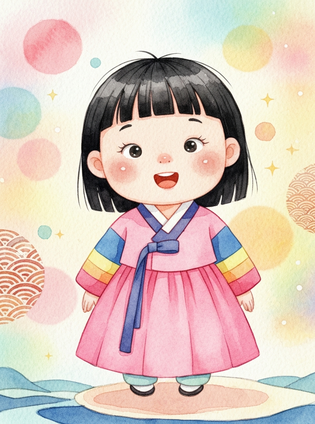


🎉 완료!
📁 파일명: cover_유민이의_특별한_한복_찾기.png


In [33]:
# 출력 파일명 생성
title = story_data['story_info']['title']
safe_title = "".join([c if c.isalnum() or c in ['_', '-'] else "_" for c in title])
cover_filename = f"cover_{safe_title}.png"

# 이미지 생성 실행
cover_path, cover_image = generate_cover_from_story(story_data, cover_filename)

print("\n🎉 완료!")
print(f"📁 파일명: {cover_path}")

## 6단계: JSON에 표지 이미지 경로 추가 및 저장

In [6]:
# JSON 데이터에 표지 이미지 경로 추가
if 'metadata' not in story_data:
    story_data['metadata'] = {}

story_data['metadata']['cover_image'] = cover_filename
story_data['metadata']['version'] = "v1.1_GPT-SoVITS_with_Imagen3"

# 업데이트된 JSON 저장
updated_json_filename = json_filename.replace('.json', '_with_cover.json')

with open(updated_json_filename, 'w', encoding='utf-8') as f:
    json.dump(story_data, f, ensure_ascii=False, indent=4)

print(f"✅ 업데이트된 JSON 저장 완료: {updated_json_filename}")
print(f"📷 표지 이미지 경로: {story_data['metadata']['cover_image']}")

✅ 업데이트된 JSON 저장 완료: 유민이의_특별한_한복_찾기_20251207_2253_with_cover.json
📷 표지 이미지 경로: cover_유민이의_특별한_한복_찾기.png


## 7단계: 파일 다운로드

In [7]:
# 표지 이미지 다운로드
print("📥 표지 이미지 다운로드 중...")
files.download(cover_filename)

# 업데이트된 JSON 다운로드
print("📥 업데이트된 JSON 다운로드 중...")
files.download(updated_json_filename)

print("\n✅ 모든 파일 다운로드 완료!")

📥 표지 이미지 다운로드 중...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📥 업데이트된 JSON 다운로드 중...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ 모든 파일 다운로드 완료!


## 8단계: 결과 확인 (선택사항)

📊 최종 결과 요약

📖 동화 제목: 유민이의 특별한 한복 찾기
🎨 표지 이미지: cover_유민이의_특별한_한복_찾기.png
📁 업데이트된 JSON: 유민이의_특별한_한복_찾기_20251207_2253_with_cover.json

🖼️ 이미지 크기: 149 x 120 pixels
📦 파일 형식: PNG

✅ 생성 완료!

📷 생성된 표지 이미지:


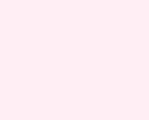

In [8]:
# 최종 결과 요약
print("="*70)
print("📊 최종 결과 요약")
print("="*70)
print(f"\n📖 동화 제목: {story_data['story_info']['title']}")
print(f"🎨 표지 이미지: {cover_filename}")
print(f"📁 업데이트된 JSON: {updated_json_filename}")
print(f"\n🖼️ 이미지 크기: 149 x 120 pixels")
print(f"📦 파일 형식: PNG")
print("\n✅ 생성 완료!")
print("="*70)

# 이미지 다시 표시
print("\n📷 생성된 표지 이미지:")
display(cover_image)

---

## 📝 사용 팁

### 이미지 품질 개선 방법:
1. **키워드 추가**: JSON의 `keywords`에 더 구체적인 한국 문화 요소 추가
2. **줄거리 수정**: `summary`를 더 시각적으로 묘사되도록 수정
3. **재생성**: 마음에 들지 않으면 5단계 셀을 다시 실행

### 문제 해결:
- **API 오류**: Gemini API 키 확인 및 할당량 확인
- **이미지 품질**: 더 큰 해상도로 생성 후 다운스케일 고려
- **한국 요소 부족**: JSON의 키워드에 더 많은 한국 문화 요소 추가

### 다음 단계:
- 생성된 이미지와 JSON을 백엔드 서버에 업로드
- 데이터베이스에 표지 이미지 경로 저장
- React Native 앱에서 표지 이미지 표시
